# Emotion classification project

The purpose of this project is to be a learning experience for myself in the realm of machine learning. This is done purely out of personal interest.
The end goal of this project is to create a classifier for emotion prediction from audio data.

Models used:
* Scikit-learn
    * Logistic regression
    * Support vector machine
    * Random forest classifier
    * XGBoost
    * Multilayer perceptron
* Keras
    * Multi-input convolutional neural network
    

## About the dataset

The Ryerson audio-visual database of emotional speech and song (RAVDESS) is a database containing audio and audio-visual files of varying emotion from total of 24 different professional actors. The full dataset contains 7356 files. This project will be using only the speech portion of audio-only files reducing the number of files to 1440 = 24 actors * 60 trials. This reduced dataset consists of two lexically-matched statements in a neutral North American accent having in total of 8 different emotional expressions of neutral, calm, happy, sad, angry, surprise and disgust. Each emotion has two intesity variants i.e. normal and strong. More info can be found at [RAVDESS](https://zenodo.org/record/1188976).

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import joblib

import librosa as lr
import librosa.feature as lrf
import librosa.display as lrd

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import scipy.stats as sst

from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D,
                                    BatchNormalization, concatenate, Normalization)

import keras_tuner as kt
from keras_tuning import build_optimized_model

from utils import (plot_metrics, img_scaler, scaler, PlotMetrics, KerasModelProgress, time_taken,
                  sklearn_cv, keras_cv, get_folds)
    
from process_data import get_processed
from time import time

np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.4f}'.format


### Chosen features and feature generation

For this project the features I have chosen to use are as follows:
* Mel-spectrograms
* MFC-coefficients
* Metadata included in audio files
    * Gender, intensity and statement. 
        * Gender is specified by actor number (even number is female uneven is male).
        * Intesity by the fourth number in file name.
        * Statement by the fifth number in the file name

These are very basic features for audio classification tasks and could absolutely be further optimized.

Parameters used for said features are:

* For __Scikit-learn__ models
    * 512 FFT window
    * 64 Mel-bands
        * Mean and standard deviation across mel-bands are calculated resulting in a feature vector of length 128
    * 20 MFC-coefficients
        * Mean and standard deviation across coefficients are calculated resulting in a feature vector of length 40
* For __Keras__ models
    * 512 FFT window
    * 128 Mel-bands
        * Mean and standard deviation across mel-bands are calculated resulting in a feature vector of length 256
    * 20 MFC-coefficients
        * Full spectrogram is used

Features and the result of augmenting a data sample is shown below. Implementation of feature extracton can be found in [process_data](process_data.py)

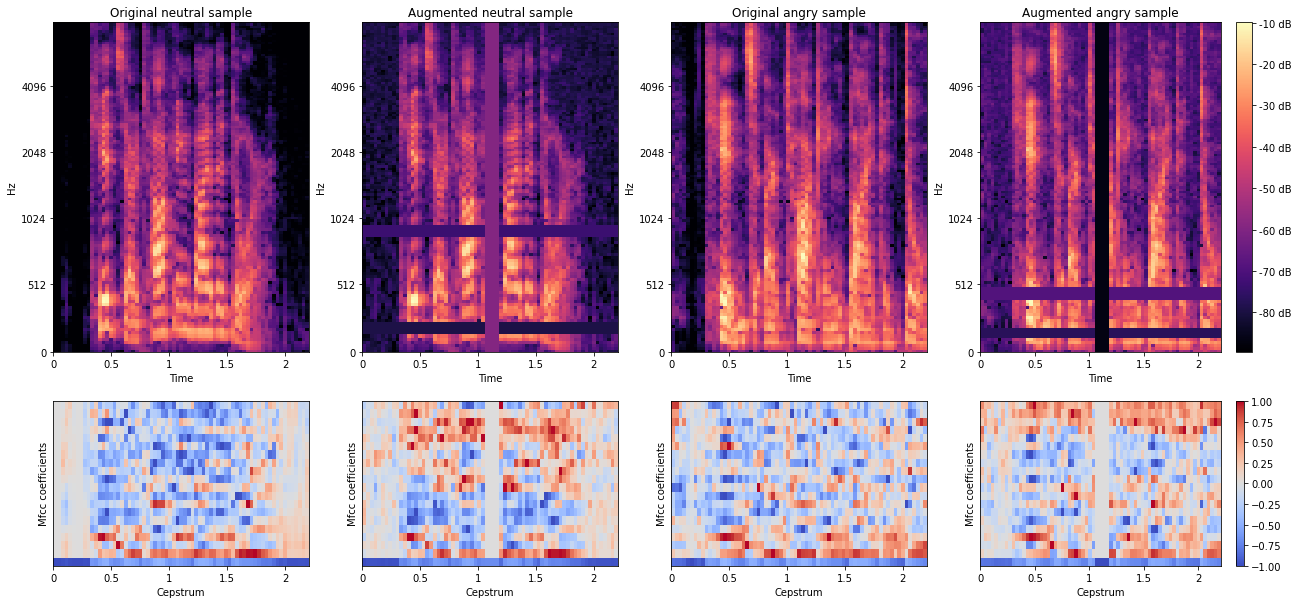

In [4]:
test_path=['speech-emotion-recognition-ravdess-data/Actor_03/03-01-01-01-01-01-03.wav',
           'speech-emotion-recognition-ravdess-data/Actor_03/03-01-05-01-01-01-03.wav']

# Get two example samples with 1 augmentation.
sample, _ = get_processed(test_path, n_augmentations=1, for_sklearn=False, n_mels=128, full_mels=True)

fig, axs = plt.subplots(2,4, figsize=(22, 10),
                        gridspec_kw={'height_ratios': [1, 0.5], 'width_ratios': [0.85, 0.85, 0.85, 1]}, sharey=False)

lrd.specshow(sample[1][0], y_axis='mel', x_axis='time', ax=axs[0,0], sr=16000)
axs[0,0].set_title('Original neutral sample')

lrd.specshow(sample[1][1], y_axis='mel', x_axis='time', ax=axs[0,1], sr=16000)
axs[0,1].set_title('Augmented neutral sample')

lrd.specshow(sample[1][2], y_axis='mel', x_axis='time', ax=axs[0,2], sr=16000)
axs[0,2].set_title('Original angry sample')

mel = lrd.specshow(sample[1][3], y_axis='mel', x_axis='time', ax=axs[0,3], sr=16000)
fig.colorbar(mel, ax=axs[0,3], format="%+2.f dB")
axs[0,3].set_title('Augmented angry sample')


lrd.specshow(lr.util.normalize(sample[0][0][:,:,0], axis=1), x_axis='time', ax=axs[1,0], sr=16000)
axs[1,0].set_xlabel('Cepstrum')
axs[1,0].set_ylabel('Mfcc coefficients')

lrd.specshow(lr.util.normalize(sample[0][1][:,:,0], axis=1), x_axis='time', ax=axs[1,1], sr=16000)
axs[1,1].set_xlabel('Cepstrum')
axs[1,1].set_ylabel('Mfcc coefficients')

lrd.specshow(lr.util.normalize(sample[0][2][:,:,0], axis=1), x_axis='time', ax=axs[1,2], sr=16000)
axs[1,2].set_xlabel('Cepstrum')
axs[1,2].set_ylabel('Mfcc coefficients')

mfcc = lrd.specshow(lr.util.normalize(sample[0][3][:,:,0], axis=1), x_axis='time', ax=axs[1,3], sr=16000)
fig.colorbar(mfcc, ax=axs[1,3])
axs[1,3].set_xlabel('Cepstrum')
axs[1,3].set_ylabel('Mfcc coefficients')

plt.show()

From above visualization, differences between spectrograms resulting from neutral and angry emotions is quite visible.
Addition of gaussian noise and the effect of frequency and time masking can also be seen.
Note that MFCCs are calculated from augmented mel-spectrograms.

## Scikit-learn model building

In [2]:
# Creation of training and testing paths. random state is used for reproducibility.
# Also guarantees that we use same test data for sklearn models and keras models in the final evaluation section.

path_list = glob.glob('speech-emotion-recognition-ravdess-data/Actor_*/*')
targets = [int(path.split('-')[6]) for path in path_list]

X_train_paths, X_test_paths = train_test_split(path_list, stratify=targets, test_size=0.10, random_state=42)

### Augmentation or no augmentation?

The idea behind data augmentation at least when training a neural network is to reduce overfitting and to imporve generalization. Since for sklearn models spectrograms are in essence flattened by taking means and standard deviations as our features it begs the question that does augmentation even work.

The route that I have taken is to cross-validate "default" sklearn classifiers with different number of augmented samples and compare the results.

For this to work correctly a custom cross-validation procedure needs to be implemented since we want the augmented samples to only reside in the traning fold and leave validation fold as is. Without this there would be bleed of samples between traning and validation folds which would result to a quite large overfitting and completely wrong CV results.

The additional bonus is that it would be possible to cross-validate every other parameter that is involved in feature extraction process for example n_fft, hop_length, mel-bands, number of mfc coefficients etc. The best way would be to make the extraction procedure to implement sklearn transformer api and as such we could include it in a pipeline.

Implementation can be seen in [sklearn_cv](utils.py)

In [ ]:
names = ['LogisticRegression', 'SVC_RBF', 'SVC_linear', 'SVC_poly', 'RandomForestClassifier', 'MLPClassifier', 'XGBClassifier']

aug_clfs = [make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, solver='liblinear')),
            make_pipeline(StandardScaler(), SVC(kernel='rbf')),
            make_pipeline(StandardScaler(), SVC(kernel='linear')),
            make_pipeline(StandardScaler(), SVC(kernel='poly')),
            make_pipeline(RandomForestClassifier()),
            make_pipeline(StandardScaler(), MLPClassifier()),
            make_pipeline(XGBClassifier(tree_method='gpu_hist', objective='multi:softmax', eval_metric='mlogloss',
                                        use_label_encoder=False, n_jobs=1))
           ]

n_augs = [0, 1, 3, 5, 7]

scores = {}

for n_aug in n_augs:
    
    print(f'\nCross-validation using {n_aug} augmentations\n')    
    
    t = time()
    cv_scores = sklearn_cv(aug_clfs, names, X_train_paths, n_folds=5, n_augmentations=n_aug, n_parallel=5)
    print(f'\nCV done, took time {time_taken(t, True)}')
    
    scores = scores|cv_scores

joblib.dump(pd.DataFrame.from_dict(scores), 'results/AugmentationResults')

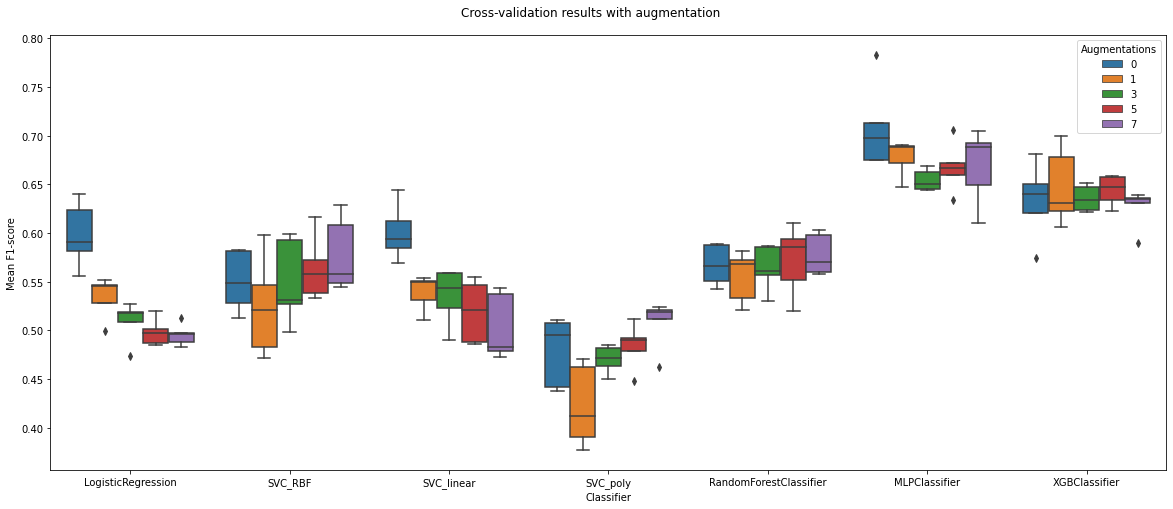

In [4]:
scores = pd.melt(joblib.load('results/AugmentationResults'), var_name=['Classifier', 'Augmentations'], value_name='Mean F1-score')

plt.figure(figsize=(20, 8))
sns.boxplot(data=scores, x='Classifier', y='Mean F1-score', hue='Augmentations')
plt.suptitle('Cross-validation results with augmentation', y=0.93)
plt.show()

As we can see from the above visualization the augmentation in this case makes more harm than good to performance. No augmentation will be done for sklearn classifiers.

### Cross-validation of default sklearn classifiers

In this section baseline perfomance is validated so we can get something to compare the later results of hyperparameter tuned models.

In [6]:
X_train, y_train = get_processed(X_train_paths)
X_test, y_test = get_processed(X_test_paths)

joblib.dump(X_train, 'data/X_train'), joblib.dump(X_test, 'data/X_test')
joblib.dump(y_train, 'data/y_train'), joblib.dump(y_test, 'data/y_test')

As a recap of features used the resulting feature array of length 171 below can be split to its component parts of ((64+64) + (20+20) + 3) = ((Mel means and standard deviations) + (MFCC means and standard deviatons) + metadata)

In [5]:
X_train, y_train = joblib.load('data/X_train'), joblib.load('data/y_train')

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')          

    
print(f'\nTrain set target class distribution:\n{pd.DataFrame(y_train).value_counts(normalize=True).sort_index()}\n')

X_train shape: (1296, 171)
y_train shape: (1296,)

Train set target class distribution:
0   0.0664
1   0.1335
2   0.1335
3   0.1335
4   0.1335
5   0.1335
6   0.1335
7   0.1327
dtype: float64



Easiest way to handle model selection is by using pipelines. It will shield us from any statistic leaks from training to validation or test sets and the whole pipeline, including feature selection, preprocessing and classification can be cross-validated and tuned.

For more information on [Scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline).

For now only simple pipelines are created that include scaling as preprocessing for classifiers that need it for permormance and convergence. For random forests and XGB scaling is not needed.

Classifiers will be validated using 10-fold cross-validation.

In [ ]:
%%time

default_classifiers = [make_pipeline(StandardScaler(), LogisticRegression()),
                       make_pipeline(StandardScaler(), SVC()),
                       make_pipeline(RandomForestClassifier()),
                       make_pipeline(StandardScaler(), MLPClassifier()),
                       make_pipeline(XGBClassifier(tree_method='gpu_hist', objective='multi:softmax', eval_metric='mlogloss',
                                                   use_label_encoder=False, n_jobs=1))]

default_results = {}

for clf in default_classifiers:
    
    name = clf[-1].__class__.__name__
    print(f'Fitting {name} with deafult parameters\n')
        
    t = time()
    result = cross_val_score(clf, X_train, y_train, scoring='f1_macro', n_jobs=-1, verbose=10, cv=10)
    print(f'Cross-validation took: {time_taken(t, True)}')

    default_results[('Default', name)] = result

joblib.dump(pd.DataFrame(default_results), 'results/DefaultSklearnResults')

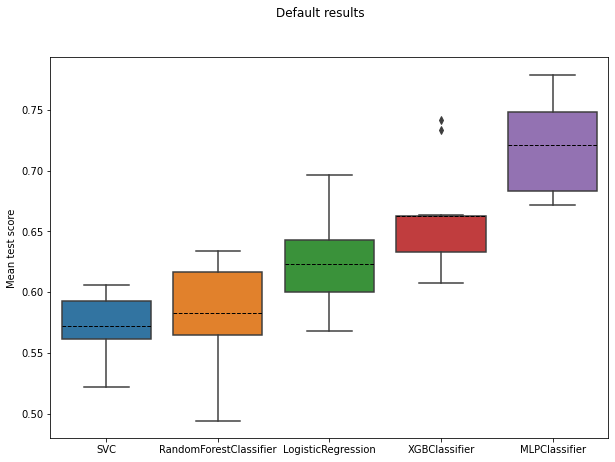


=====Cross-validation metrics======

With estimator: MLPClassifier

Mean F1-score: 0.721
Standard deviation: 0.037

============== END ===============


=====Cross-validation metrics======

With estimator: XGBClassifier

Mean F1-score: 0.663
Standard deviation: 0.041

============== END ===============


=====Cross-validation metrics======

With estimator: LogisticRegression

Mean F1-score: 0.623
Standard deviation: 0.036

============== END ===============


=====Cross-validation metrics======

With estimator: RandomForestClassifier

Mean F1-score: 0.583
Standard deviation: 0.039

============== END ===============


=====Cross-validation metrics======

With estimator: SVC

Mean F1-score: 0.572
Standard deviation: 0.024

============== END ===============



In [36]:
default_results = joblib.load('results/DefaultSklearnResults')['Default']

sorted_columns = default_results.mean().sort_values().index

sorted_default_results = default_results[sorted_columns]

plt.figure(figsize=(10,7))

sns.boxplot(data=sorted_default_results, medianprops={'linestyle':'None'}, showmeans=True,
            meanline=True, meanprops={'color':'black'})
plt.ylabel('Mean test score')
plt.xlabel(None)
plt.suptitle('Default results')
plt.show()

for col in np.flip(sorted_columns):
    
    score = np.mean(default_results[col])
    std = np.std(default_results[col])
    
    print('\n=====Cross-validation metrics======\n')
    print(f'With estimator: {col}\n')
    print(f"Mean F1-score: {round(score, 3)}")
    print(f"Standard deviation: {round(std, 3)}\n")
    print('============== END ===============\n')
    

### Hyperparameter search results

Next step is to tune the hyperparameters of chosen classifiers. Pipelines and parameter grids can be viewed here [sklearn_tuning](sklearn_tuning.py). Implementation of the search used can be seen in here [incremental_search](incremental_search.py).

Searches performed for individual classifiers were as follows:
* LogisticRegression
    * 5-fold
    * 2000 hyperparameters
* SVC
    * 5-fold
    * 5000 hyperparameters
* RandomForestClassifier
    * 5-fold
    * 1500 hyperparameters
* MLPClassifier
    * 5-fold
    * 1500 hyperparameters
* XGBClassifier
    * 4-fold
    * 1500 hyperparameters
    
Differences between the number of sampled hyperparameter combinations is do to the size of defined search space and the time it takes to fit a given classifier i.e. SVC fits almost instantly and XGB is in comparison very slow.

Let's load the search results and see best performing hyperparameters for each classifier.

In [2]:
names = ['LogisticRegression', 'SVC', 'RandomForestClassifier', 'MLPClassifier', 'XGBClassifier']
paths = [('searches/'+name+'Search', 'searches/'+name+'Results') for name in names]

searches, results = [], []

for p1, p2 in paths:
    searches.append(joblib.load(p1))
    results.append(joblib.load(p2))

In [3]:
columns_to_show = ['mean_test_score', 'std_test_score', 'rank_test_score', 'n_samples', 'params']

for i, name in enumerate(names):
    
    sorted_results = results[i][columns_to_show].sort_values(['mean_test_score'], ascending=False)
    
    with pd.option_context('display.max_colwidth', -1):
        print('\nTop 3 best performing parameters for model: '+name)
        display(sorted_results[:3])


Top 3 best performing parameters for model: LogisticRegression


,mean_test_score,std_test_score,rank_test_score,n_samples,params
334,0.6188,0.0162,1,1296,"{'clf__C': 5.182323505895209, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'scaler': MinMaxScaler()}"
125,0.6183,0.0175,2,1296,"{'clf__C': 5.1096007572985185, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'scaler': MinMaxScaler()}"
529,0.6176,0.0137,3,1296,"{'clf__C': 5.642107090110922, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'scaler': MinMaxScaler()}"



Top 3 best performing parameters for model: SVC


,mean_test_score,std_test_score,rank_test_score,n_samples,params
3913,0.7375,0.0303,1,1296,"{'clf__C': 4.073181932046468, 'clf__gamma': 1.0070740558594764, 'clf__kernel': 'rbf', 'decomp': PCA(n_components=0.99), 'scaler2': MinMaxScaler()}"
3059,0.7348,0.0212,2,1296,"{'clf__C': 3.7389329023788513, 'clf__gamma': 0.015317140891398554, 'clf__kernel': 'rbf', 'decomp': PCA(n_components=0.99), 'scaler2': StandardScaler()}"
1745,0.7304,0.0216,3,1296,"{'clf__C': 9.812414648924417, 'clf__gamma': 0.0054615296005484995, 'clf__kernel': 'rbf', 'decomp': PCA(), 'scaler2': 'passthrough'}"



Top 3 best performing parameters for model: RandomForestClassifier


,mean_test_score,std_test_score,rank_test_score,n_samples,params
534,0.6407,0.0225,1,1296,"{'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__max_features': 30, 'clf__criterion': 'entropy', 'clf__bootstrap': False}"
779,0.6367,0.0245,2,1296,"{'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__max_features': 31, 'clf__criterion': 'entropy', 'clf__bootstrap': False}"
236,0.6341,0.0336,3,1296,"{'clf__n_estimators': 500, 'clf__min_samples_split': 4, 'clf__max_features': 27, 'clf__criterion': 'entropy', 'clf__bootstrap': False}"



Top 3 best performing parameters for model: MLPClassifier


,mean_test_score,std_test_score,rank_test_score,n_samples,params
364,0.7449,0.0281,1,1296,"{'scaler': StandardScaler(), 'clf__max_iter': 900, 'clf__learning_rate_init': 0.002, 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (512, 64), 'clf__batch_size': 128, 'clf__activation': 'relu'}"
1267,0.7439,0.0268,2,1296,"{'scaler': StandardScaler(), 'clf__max_iter': 900, 'clf__learning_rate_init': 0.002, 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (256,), 'clf__batch_size': 64, 'clf__activation': 'relu'}"
1371,0.7433,0.0309,3,1296,"{'scaler': StandardScaler(), 'clf__max_iter': 300, 'clf__learning_rate_init': 0.002, 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (512,), 'clf__batch_size': 64, 'clf__activation': 'relu'}"



Top 3 best performing parameters for model: XGBClassifier


,mean_test_score,std_test_score,rank_test_score,n_samples,params
1897,0.6654,0.0296,1,1296,"{'clf__colsample_bytree': 0.9007123166538439, 'clf__eval_metric': 'mlogloss', 'clf__gamma': 0.06126780910439317, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_child_weight': 2, 'clf__n_estimators': 500, 'clf__objective': 'multi:softmax', 'clf__subsample': 0.7671253776764335, 'clf__tree_method': 'gpu_hist'}"
227,0.6638,0.0327,2,1296,"{'clf__colsample_bytree': 0.7886879685162956, 'clf__eval_metric': 'mlogloss', 'clf__gamma': 0.011689319600720813, 'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__min_child_weight': 2, 'clf__n_estimators': 500, 'clf__objective': 'multi:softmax', 'clf__subsample': 0.5318214214489826, 'clf__tree_method': 'gpu_hist'}"
241,0.6630,0.0249,3,1296,"{'clf__colsample_bytree': 0.5924101307502787, 'clf__eval_metric': 'mlogloss', 'clf__gamma': 0.002617805884371923, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_child_weight': 2, 'clf__n_estimators': 500, 'clf__objective': 'multi:softmax', 'clf__subsample': 0.6181436488221598, 'clf__tree_method': 'gpu_hist'}"


### Cross-validation of tuned sklearn classifiers

In this section the new optimized classifiers are cross-validated to validate the desired improvement in perfomance. Same 10-fold cross-validation is used.

It has to be noted that searching for hyperparameters and after that cross-validating on the same training set introduces a bias as models are overfitting to the traning set. Correct way would be to perform hp search and cross-validation in a nested fashion. That is to say the whole search procedure should be cross-validated. This would introduce as many times more calculation to perform as there are "outer" cross-validation folds so in this case 10 more times. I will for now refrein on implementing this because of the time cost. In turn one needs to be mindful of the fact that the below generalization results are quite probably bit lower in reality.

More information on [nested cross-validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html).

In [ ]:
%%time

optimized_results = {}

for i, name in enumerate(names):
    
    print(f'Fitting model {name} with best parameters\n')
    
    opt_estimator = searches[i][-1].best_estimator_
        
    t = time()
    result = cross_val_score(opt_estimator, X_train, y_train, scoring='f1_macro', n_jobs=-1, verbose=10, cv=10)
    time_taken(t, True)

    optimized_results[('Optimized', name)] = result

joblib.dump(pd.DataFrame(optimized_results), 'results/OptimizedSklearnResults')

New results are visualized below. Comparison and discussion is done in section Final evaluation for all classifiers.

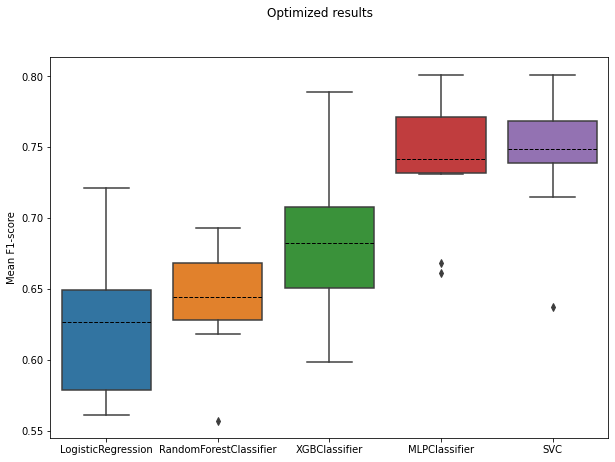


=====Cross-validation metrics======

With classifier: SVC

Mean F1-score: 0.749
Standard deviation: 0.044

============== END ===============


=====Cross-validation metrics======

With classifier: MLPClassifier

Mean F1-score: 0.742
Standard deviation: 0.045

============== END ===============


=====Cross-validation metrics======

With classifier: XGBClassifier

Mean F1-score: 0.682
Standard deviation: 0.05

============== END ===============


=====Cross-validation metrics======

With classifier: RandomForestClassifier

Mean F1-score: 0.644
Standard deviation: 0.038

============== END ===============


=====Cross-validation metrics======

With classifier: LogisticRegression

Mean F1-score: 0.627
Standard deviation: 0.052

============== END ===============



In [7]:
optimized_results = joblib.load('results/OptimizedSklearnResults')['Optimized']

sorted_columns = optimized_results.mean().sort_values().index

sorted_optimized_results = optimized_results[sorted_columns]

plt.figure(figsize=(10,7))

sns.boxplot(data=sorted_optimized_results, medianprops={'linestyle':'None'}, showmeans=True,
            meanline=True, meanprops={'color':'black'})
plt.ylabel('Mean F1-score')
plt.xlabel(None)
plt.suptitle('Optimized results')
plt.show()

for col in np.flip(sorted_columns):
    
    score = np.mean(optimized_results[col])
    std = np.std(optimized_results[col])
    
    print('\n=====Cross-validation metrics======\n')
    print(f'With classifier: {col}\n')
    print(f"Mean F1-score: {round(score, 3)}")
    print(f"Standard deviation: {round(std, 3)}\n")
    print('============== END ===============\n')
    

### Final fit

Final fitting of optimized classifiers for out-of-sample evaluation.

In [ ]:
%%time

best_classifiers = [searches[i][-1].best_estimator_ for i in range(len(names))]

for clf in best_classifiers:
    
    print(f'Fitting {clf[-1].__class__.__name__}\n')
    clf.fit(X_train, y_train)
    
    joblib.dump(clf, 'models/'+clf[-1].__class__.__name__)

## Keras convolutional neural network

In this section I wanted to make a bit more involved neural network. Network will be implemented using keras as framework.

For this section I chose to use full MFCC-spectrograms as features and as they can be interpreted as images, standard image classification techniques i.e. convolutional layers can be used.
Mel-spectrograms are processed similarly than before but using double the amount of mel filter bands. Full mel-spectrograms were tried as features in a similar manner as MFCCs with convolutional layers but it introduced overfitting problems and results turned out not fruitful.

Model ended up being a multi-input model that combines convolutional layers (MFCCs) and dense layers (Mel and metadata) that are concatonated together in the middle of the network. Graph of the initial model can be viewed [here](keras/DefaultConv2DGraph.png)

### Creating traning, validation and test data

For this section additional validation set is created for model progress tracking.

__Note__ that the training set will be augmented for this section with three samples.

In [2]:
path_list = glob.glob('speech-emotion-recognition-ravdess-data/Actor_*/*')
path_targets = [int(path.split('-')[6]) for path in path_list]

In [ ]:
%%time

X_paths, X_test_paths = train_test_split(path_list, stratify=path_targets, test_size=0.10, random_state=42)
X_train_paths, X_val_paths = train_test_split(X_paths, stratify=[int(path.split('-')[6]) for path in X_paths], test_size=0.10)

X_train_keras, y_train_keras = get_processed(X_train_paths, n_augmentations==3, for_sklearn=False, n_mels=128)
X_val_keras, y_val_keras = get_processed(X_val_paths, for_sklearn=False, n_mels=128)
X_test_keras, _ = get_processed(X_test_paths, for_sklearn=False, n_mels=128)

y_train_keras = keras.utils.to_categorical(y_train_keras, 8)
y_val_keras = keras.utils.to_categorical(y_val_keras, 8)

joblib.dump(X_paths, 'data/X_paths')

joblib.dump(X_train_keras, 'data/X_train_keras'), joblib.dump(X_val_keras, 'data/X_val_keras'), joblib.dump(X_test_keras, 'data/X_test_keras')

joblib.dump(y_train_keras, 'data/y_train_keras'), joblib.dump(y_val_keras, 'data/y_val_keras')

In [3]:
X_train_keras, X_val_keras = joblib.load('data/X_train_keras'), joblib.load('data/X_val_keras')
y_train_keras, y_val_keras = joblib.load('data/y_train_keras'), joblib.load('data/y_val_keras')

# Scaling of mel data array
X_train_keras[1], X_val_keras[1] = scaler(X_train_keras[1], X_val_keras[1])

# Combine training and validation splits for final model fitting.
X_keras = [np.vstack((a, b)) for a, b in zip(X_train_keras, X_val_keras)]
y_keras = np.vstack((y_train_keras, y_val_keras))

print('Feature shapes:\n')
print('Mfcc: ', X_train_keras[0].shape[1:])
print('Mel data: ', X_train_keras[1].shape[1:])
print('Metadata: ', X_train_keras[2].shape[1:], '\n')

print('Set sizes: \n')
print('X_keras (X_train + X_val): ', X_keras[1].shape[0])
print('X_train: ', X_train_keras[1].shape[0])
print('X_val: ', X_val_keras[1].shape[0])


Feature shapes:

Mfcc:  (20, 69, 1)
Mel data:  (256,)
Metadata:  (3,) 

Set sizes: 

X_keras (X_train + X_val):  4794
X_train:  4664
X_val:  130


### Default Keras classifier

Let's define a default classifier and fit it to get a baseline performance results.

In [2]:
def build_default_model():
    
    input1 = Input((20, 69, 1))
    
    x1 = Conv2D(32, 3, activation='relu', padding='same')(input1)
    x1 = Conv2D(32, 3, activation='relu', padding='same')(x1)
    x1 = MaxPooling2D(pool_size=(3,3))(x1)

    x1 = Conv2D(64, 3, activation='relu', padding='same')(x1)
    x1 = Conv2D(64, 3, activation='relu', padding='same')(x1)
    x1 = MaxPooling2D(pool_size=(3,3))(x1)

    flat1 = Flatten()(x1)
    flat1 = Dropout(0.5)(flat1)
    
    input2 = Input((256,))
    
    input3 = Input((3,))
    
    x2 = concatenate([input2, input3])
    
    x2 = Dense(64, activation='relu')(x2)
        
    merge = concatenate([flat1, x2])

    x = Dense(256, activation='relu')(merge)
    x = Dropout(0.5)(x)
    
    output = Dense(8, activation='softmax')(x)
    
    model = Model(inputs=[input1, input2, input3], outputs=output)
                      
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [3]:
default_keras = build_default_model()

default_keras.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 69, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 20, 69, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 20, 69, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 6, 23, 32)    0           ['conv2d_1[0][0]']               
                                                                                              

In [ ]:
plot_model(default_keras, show_shapes=True, dpi=96, to_file='images/DefaultConv2DGraph.png')

Visualizing traning progress of default classifier.

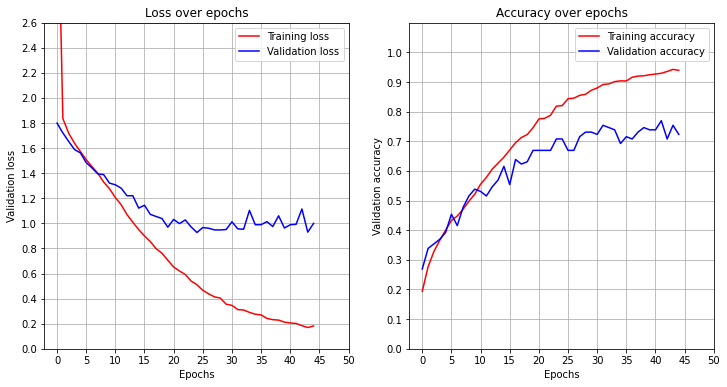

600/600 [==============================] - 6s 10ms/step - loss: 0.5105 - accuracy: 0.8229


['results/DefaultConv2DHistory']

In [10]:
def scheduler(epoch, lr):
    if epoch == 50 or epoch == 70 or epoch == 90:
        return lr*0.5
    else:
        return lr

default_history = default_keras.fit([X_train_keras[0], X_train_keras[1], X_train_keras[2]], y_train_keras,
                                    batch_size=8, epochs=90,
                                    validation_data=([X_val_keras[0], X_val_keras[1], X_val_keras[2]], y_val_keras),
                                    shuffle=True,
                                    callbacks=[keras.callbacks.LearningRateScheduler(scheduler),
                                               PlotMetrics()])

#### Cross-validation

For keras models cross-validation is also performed. As in sklearn section a custom cross-validation is implemented to account for the fact that we use augmentation in the training folds.
Implementation is found here [keras_cv](utils.py).

See section Cross-validation results at the end of the notebook for comparison between sklearn estimators.

In [ ]:
X_paths, _ = train_test_split(path_list, stratify=path_targets, test_size=0.10, random_state=42)

default_cv_scores = {}

folds = get_folds(X_paths, n_augmentations=3, n_folds=10, for_sklearn=False)

t = time()
f1s, losses = keras_cv(build_default_model, hp=None, folds=folds, epochs=70, n_updates=6)
print(f'\nCV done, took time {time_taken(t, True)}')

default_cv_scores['F1'] = f1s
default_cv_scores['Loss'] = losses

joblib.dump(pd.DataFrame(default_cv_scores), 'results/DefaultKerasCVResults')

### Optimized Keras classifier

For hyperparameter tuning I chose to use keras tuner. Since fitting a neural network is time consuming only 250 hyperparameter candidates were evaluated. Search was done using BayesianOptimization which uses a gaussian process for choosing promising hyperparameter combinations using previous search results as a guide.

As a search objective minimizing validation categorical cross-entropy was used. Implementation of the search can be viewed in here [keras_tuning](keras_tuning.py).

Graph of the optimized model can be viewed in [here](keras/OptimizedConv2DGraph.png).

In [ ]:
# Search directory is too large to include in github so this code block will be unusable.

tuner = kt.BayesianOptimization(build_optimized_model, objective='val_loss', max_trials=250, num_initial_points=50,                                 
                                    directory = 'keras/search')

best_hps = [hp for hp in tuner.get_best_hyperparameters(num_trials=20)]
joblib.dump(best_hps, 'searches/KerasHPs')

Below are the 20 best performing hyperparameter combinations.

In [4]:
best_hps = joblib.load('searches/KerasHPs')
pd.DataFrame([hp.values for hp in best_hps]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
filters1,32,96,32,64,96,32,32,96,32,64,96,32,32,32,32,64,32,64,96,64
batchnorm1,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,False,True,True,True,True
dropout1,0.0000,0.0000,0.0000,0.0000,0.0000,0.1000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2000
filters2,32,32,32,32,32,32,32,32,32,32,64,32,32,32,32,32,32,32,32,96
dropout2,0.3000,0.4000,0.4000,0.0000,0.0000,0.4000,0.0000,0.5000,0.3000,0.0000,0.5000,0.5000,0.4000,0.0000,0.0000,0.5000,0.2000,0.0000,0.0000,0.5000
filters3,192,192,192,64,128,192,64,192,192,64,64,64,96,64,64,64,192,64,128,96
batchnorm2,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,True
dropout3,0.0000,0.0000,0.0000,0.0000,0.0000,0.1000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1000,0.1000,0.0000,0.0000,0.1000,0.1000,0.0000,0.0000,0.2000
filters4,192,128,128,96,96,128,64,128,192,96,96,96,64,96,64,96,192,96,64,64
dropout4,0.7500,0.5562,0.6552,0.7500,0.7080,0.5194,0.7500,0.4635,0.7500,0.7500,0.2649,0.3542,0.4224,0.7500,0.7500,0.3780,0.7382,0.7500,0.7500,0.2439


In [5]:
optimized_keras = build_optimized_model(best_hps[0])

optimized_keras.summary()

Model: "OptimizedConv2D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 69, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 20, 69, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 69, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 20, 69, 32)   9248        ['batch_normalizati

In [ ]:
plot_model(optimized_keras, show_shapes=True, dpi=96, to_file='images/OptimizedConv2DGraph.png')

Visualizing training progress of optimized classifier.

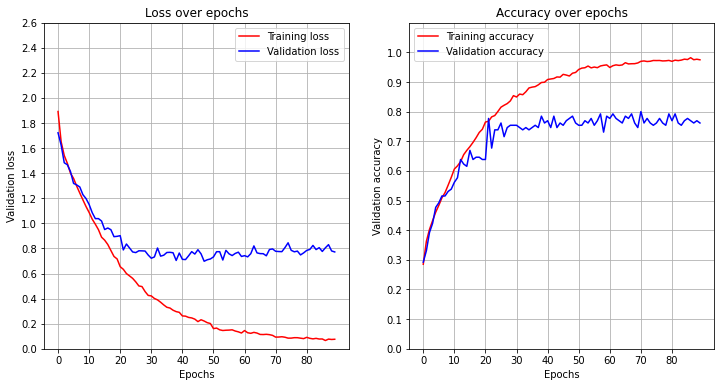

583/583 [==============================] - 7s 12ms/step - loss: 0.0761 - accuracy: 0.9747 - val_loss: 0.7720 - val_accuracy: 0.7615 - lr: 2.5000e-05


In [6]:
def scheduler(epoch, lr):
    if epoch == 50 or epoch == 70 or epoch == 90:
        return lr*0.5
    else:
        return lr

optimized_keras.fit([X_train_keras[0], X_train_keras[1], X_train_keras[2]], y_train_keras,
                     batch_size=8, epochs=90,
                     validation_data=([X_val_keras[0], X_val_keras[1], X_val_keras[2]], y_val_keras),
                     shuffle=True,
                     callbacks=[keras.callbacks.LearningRateScheduler(scheduler),
                                PlotMetrics()])

#### Cross-validation

For the resulting best model I wanted to see how the amount of epochs the model is trained will effect the resulting validation F1 score and loss. Different amount of epochs were tried in a loop and the results are viewed below.

In [ ]:
%%time

X_paths, _ = train_test_split(path_list, stratify=path_targets, test_size=0.10, random_state=42)

best_hps = joblib.load('searches/KerasHPs')

epoch_list = [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]

f1_scores = {}
losses_dict = {}

folds = get_folds(X_paths, n_augmentations=3, n_folds=10, for_sklearn=False)

for epoch in epoch_list:
    
    print(f'\nCross-validation using {epoch} epochs\n')
    
    t = time()
    f1s, losses = keras_cv(build_optimized_model, best_hps[0], folds, epochs=epoch, n_updates=6)
    print(f'\nCV done, took time {time_taken(t, True)}')
    
    print('\n============= END ==============')
    
    f1_scores[epoch] = f1s
    losses_dict[epoch] = losses
        
joblib.dump([pd.DataFrame(f1_scores), pd.DataFrame(losses_dict)], 'results/OptimizedKerasCVResults')

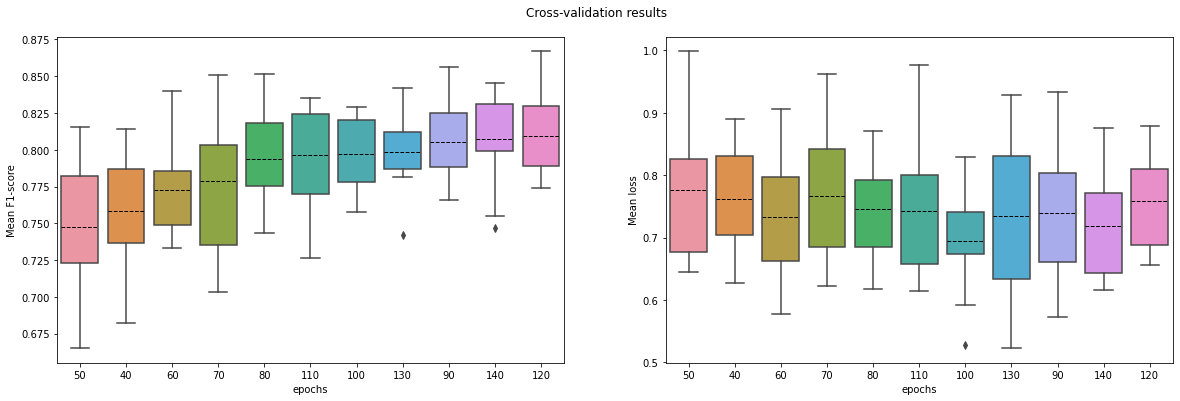


==== Cross-validation metrics =====

Using epochs 120  

Mean F1-score: 0.81
Standard deviation: 0.028

Mean loss: 0.759
Standard deviation: 0.074

============== END ===============


==== Cross-validation metrics =====

Using epochs 140  

Mean F1-score: 0.807
Standard deviation: 0.032

Mean loss: 0.719
Standard deviation: 0.088

============== END ===============


==== Cross-validation metrics =====

Using epochs 90  

Mean F1-score: 0.805
Standard deviation: 0.028

Mean loss: 0.74
Standard deviation: 0.11

============== END ===============


==== Cross-validation metrics =====

Using epochs 130  

Mean F1-score: 0.798
Standard deviation: 0.026

Mean loss: 0.734
Standard deviation: 0.128

============== END ===============


==== Cross-validation metrics =====

Using epochs 100  

Mean F1-score: 0.797
Standard deviation: 0.026

Mean loss: 0.694
Standard deviation: 0.082

============== END ===============


==== Cross-validation metrics =====

Using epochs 110  

Mean F1-score: 0

In [8]:
f1s, losses = joblib.load('results/OptimizedKerasCVResults')

sorted_columns = f1s.mean().sort_values().index

sorted_f1s = f1s[sorted_columns]
sorted_losses = losses[sorted_columns]

fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

sns.boxplot(data=sorted_f1s, ax=ax1, medianprops={'linestyle':'None'}, showmeans=True, meanline=True, meanprops={'color':'black'})
ax1.set_ylabel('Mean F1-score')
ax1.set_xlabel('epochs')

sns.boxplot(data=sorted_losses, ax=ax2, medianprops={'linestyle':'None'}, showmeans=True, meanline=True, meanprops={'color':'black'})
ax2.set_ylabel('Mean loss')
ax2.set_xlabel('epochs')

plt.suptitle('Cross-validation results', y=0.95)
plt.show()

for col in np.flip(sorted_columns):

    f1 = np.mean(f1s[col])
    f1_std = np.std(f1s[col])

    loss = np.mean(losses[col])
    loss_std = np.std(losses[col])

    print('\n==== Cross-validation metrics =====\n')
    print(f'Using epochs {col}  \n')
    print(f"Mean F1-score: {round(f1, 3)}")
    print(f"Standard deviation: {round(f1_std, 3)}\n")
    print(f"Mean loss: {round(loss, 3)}")
    print(f"Standard deviation: {round(loss_std, 3)}\n")
    print('============== END ===============\n')

Now the question is which validation metric should we emphasize more for model selection? Should we train the model for the number of epochs that resulted in a highest F1-score, lowest validation loss or should we choose some happy medium between the two. Loss is generally the metric that is used in neural net selection because is mesures how certain the model is about its own predictions and as such should lead to better generalization.

For this case I chose the compromise i.e. the model should be trained for 140 epochs as it resulted in a second highest F1-score and second lowest validation loss.

In [ ]:
def scheduler(epoch, lr):
    if epoch == 50 or epoch == 70 or epoch == 90:
        return lr*0.5
    else:
        return lr

optimized_keras.fit([X_keras[0], X_keras[1], X_keras[2]], y_keras,
                    epochs=140, batch_size=8, callbacks=[keras.callbacks.LearningRateScheduler(scheduler)])

optimized_keras.save('models/OptimizedConv2DClassifier.h5')

joblib.dump(optimized_history.history, 'results/OptimizedConv2DHistory')

## Final evaluation for all classifiers

In this section cross-validation and out-of-sample evaluation (evaluation using test set) results are presented. Differences between default and optimized results are also visualized.

### Cross-validation results

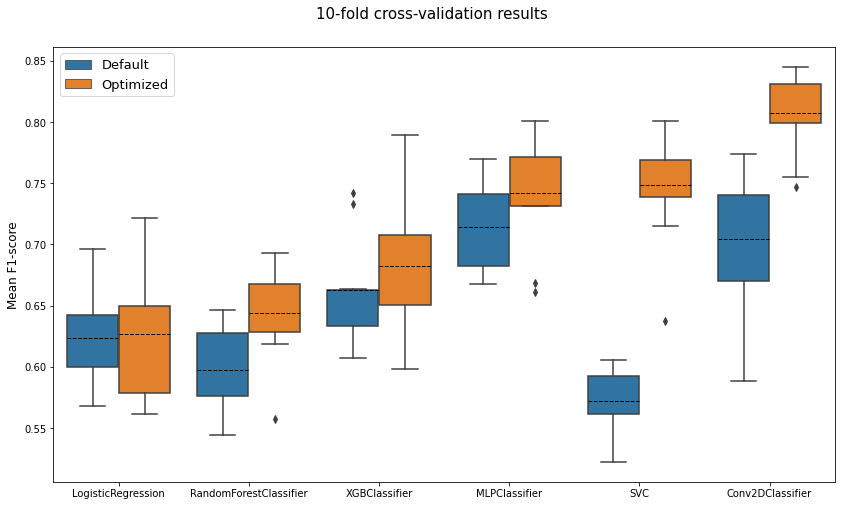


Metrics for optimized classifiers

==== Cross-validation metrics ====

With estimator: Conv2DClassifier

Mean F1-score: 0.807
Standard deviation: 0.032

============== END ================


==== Cross-validation metrics ====

With estimator: SVC

Mean F1-score: 0.749
Standard deviation: 0.044

============== END ================


==== Cross-validation metrics ====

With estimator: MLPClassifier

Mean F1-score: 0.742
Standard deviation: 0.045

============== END ================


==== Cross-validation metrics ====

With estimator: XGBClassifier

Mean F1-score: 0.682
Standard deviation: 0.05

============== END ================


==== Cross-validation metrics ====

With estimator: RandomForestClassifier

Mean F1-score: 0.644
Standard deviation: 0.038

============== END ================


==== Cross-validation metrics ====

With estimator: LogisticRegression

Mean F1-score: 0.627
Standard deviation: 0.052

============== END ================



In [9]:
default_cv, optimized_cv = joblib.load('results/DefaultSklearnResults'), joblib.load('results/OptimizedSklearnResults')
default_keras_cv, optimized_keras_cv = joblib.load('results/DefaultKerasCVResults'), joblib.load('results/OptimizedKerasCVResults')[0]

default_cv[('Default', 'Conv2DClassifier')] = default_keras_cv['F1']
optimized_cv[('Optimized', 'Conv2DClassifier')] = optimized_keras_cv[140]

optimized_cv = optimized_cv[optimized_cv.mean().sort_values().index]

optimized_cv_l = pd.melt(optimized_cv, var_name=['Type', 'Classifier'], value_name='F1-score')
default_cv_l = pd.melt(default_cv, var_name=['Type', 'Classifier'], value_name='F1-score')

all_scores = pd.concat((default_cv_l, optimized_cv_l))

plt.figure(figsize=(14,8))
plot = sns.boxplot(x='Classifier',  hue='Type', y='F1-score', data=all_scores, order=optimized_cv['Optimized'].columns,
                   medianprops={'linestyle':'None'}, showmeans=True, meanline=True, meanprops={'color':'black'})

plot.set_ylabel('Mean F1-score', fontsize=12)
plot.set_xlabel(None)
plt.suptitle('10-fold cross-validation results', fontsize=15, y=0.95)
plt.legend(fontsize=13)
plt.savefig('images/CVResults.png', bbox_inches='tight', facecolor='white')
plt.show()

print('\nMetrics for optimized classifiers')

for col in np.flip(optimized_cv.columns):
    score = round(np.mean(optimized_cv[col]), 3)
    std = round(np.std(optimized_cv[col]), 3)
    
    print('\n==== Cross-validation metrics ====\n')
    print(f'With estimator: {col[1]}\n')
    print(f"Mean F1-score: {score}")
    print(f"Standard deviation: {std}\n")
    print('============== END ================\n')

As is seen, Keras model performed the best with the worst one being linear regression. SVC had the greatest increase in performance when default and optimized performance are compared. I personally would have thought that XGBClassifier would have performed better than it did. 

### Out-of-sample evaluation results

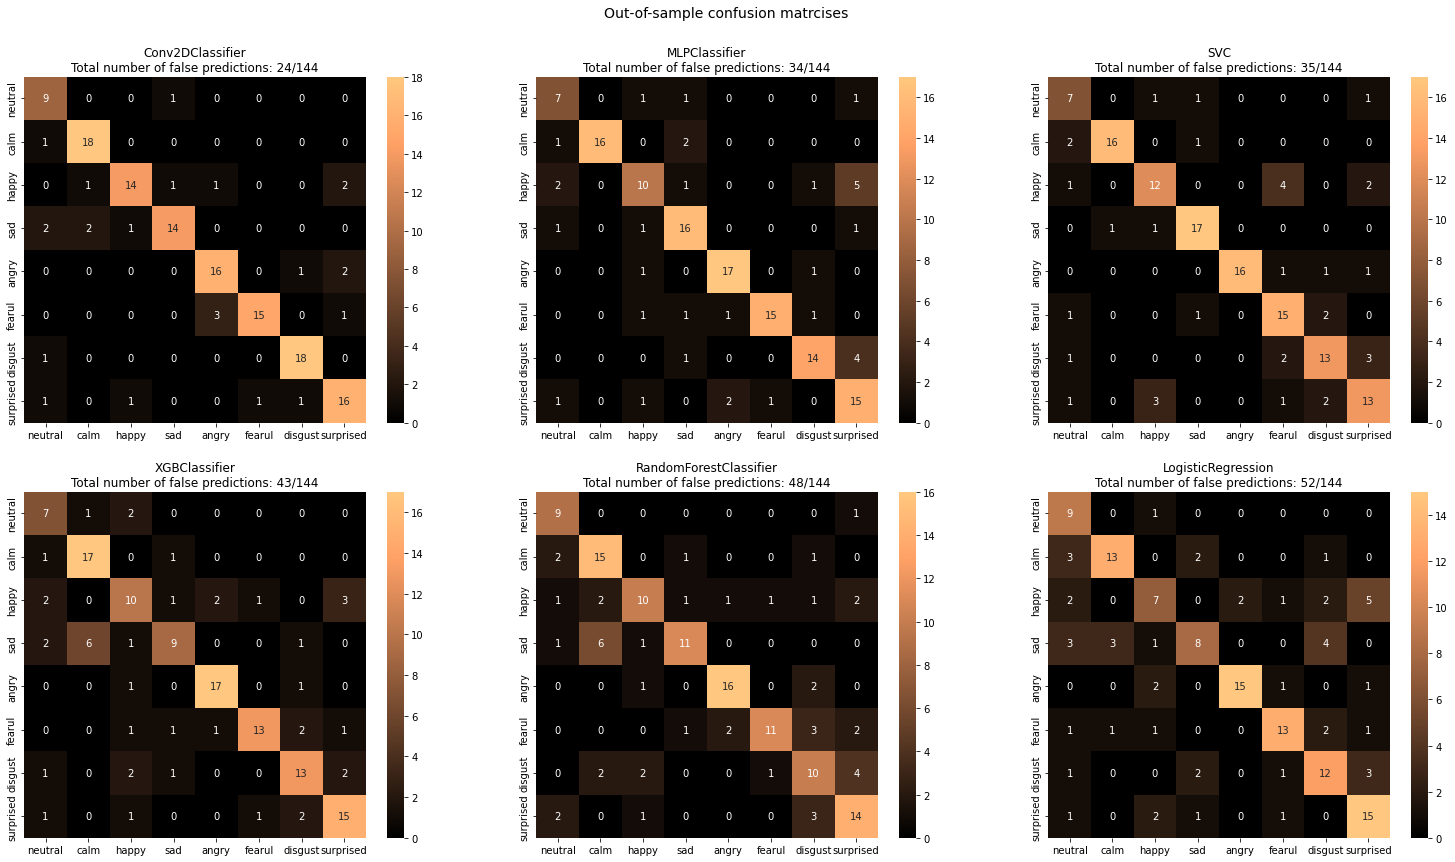


========= Evaluation ==========

With estimator: Conv2DClassifier

F1-score: 0.829
Accuracy: 0.833

============ END ==============


========= Evaluation ==========

With estimator: MLPClassifier

F1-score: 0.76
Accuracy: 0.764

============ END ==============


========= Evaluation ==========

With estimator: SVC

F1-score: 0.752
Accuracy: 0.757

============ END ==============


========= Evaluation ==========

With estimator: XGBClassifier

F1-score: 0.691
Accuracy: 0.701

============ END ==============


========= Evaluation ==========

With estimator: RandomForestClassifier

F1-score: 0.669
Accuracy: 0.667

============ END ==============


========= Evaluation ==========

With estimator: LogisticRegression

F1-score: 0.634
Accuracy: 0.639

============ END ==============



In [10]:
X_test, y_test = joblib.load('data/X_test'), joblib.load('data/y_test')
X_train_keras, X_test_keras = joblib.load('data/X_train_keras'), joblib.load('data/X_test_keras')

names = ['LogisticRegression', 'SVC', 'RandomForestClassifier', 'MLPClassifier', 'XGBClassifier']

target_labels = ['neutral',
                 'calm',
                 'happy',
                 'sad',
                 'angry',
                 'fearul',
                 'disgust',
                 'surprised']

clfs = [joblib.load('models/'+name) for name in names]

temp = [(name, clf.predict(X_test), f1_score(y_test, clf.predict(X_test), average='macro')) for clf, name in zip(clfs, names)]

clf_keras = keras.models.load_model('models/OptimizedConv2DClassifier.h5')

X_train_keras[1], X_test_keras[1] = scaler(X_train_keras[1], X_test_keras[1])

y_pred_keras = np.argmax(clf_keras.predict([X_test_keras[0], X_test_keras[1], X_test_keras[2]]), axis=-1)
f1_keras = f1_score(y_test, y_pred_keras, average='macro')

temp.append(('Conv2DClassifier', y_pred_keras, f1_keras))

sorted_clfs = sorted(temp, key=lambda x: x[2], reverse=True)

fig, axs = plt.subplots(2, 3, figsize=(26,14))

axlist = axs.flatten()

for ax, (name, y_pred, f1) in zip(axlist, sorted_clfs):
    
    cm = confusion_matrix(y_test, y_pred)
    fp = cm.sum(axis=0) - np.diag(cm)  
    sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='copper', xticklabels=target_labels, yticklabels=target_labels)
    ax.set_title(f'{name}\nTotal number of false predictions: {sum(fp)}/{len(y_test)}')
    
fig.suptitle('Out-of-sample confusion matrcises', fontsize=14, y=0.95)
plt.savefig('images/ConfusionMatrices', bbox_inches='tight', facecolor='white')
plt.show()

for name, y_pred, f1 in sorted_clfs:

    print('\n========= Evaluation ==========\n')
    print(f'With estimator: {name}\n')
    print(f"F1-score: {round(f1, 3)}")
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)}\n")
    print('============ END ==============\n')

As was expected from the cross-validation results the Keras model did best on predicting unseen data with the runner-ups being MLPClassifier and SVC. 

Personally I am quite happy with the over 0.8 F1-score. I would have thought that the Keras model would have performed not as good as it did since the optimized model ended ap having almost 1.2 million trainable parameters with only 1440 data to train on combined with the fact that neural networks are at least in general known to be very data hungry. Obvously I am not complaining.

## Further discussion and possible imporvement

There are many things that could be done better in this project and it is still very much a working progress.

First things for improvement that come to mind are:
    
* Overhaul of audio processing and feature extraction with clearer class impelementation. Sklearn api implementation would be interesting since feature extraction itself could be hyperparameter searched.
* Features other than Mel-spectrograms and MFCCs could be used and evaluated.
* Class implementation for custom cross-validation that combine both sklearn_cv and keras_cv.
* As was discussed at the start of the notebook, only one section of data was used from the dataset and it would be interesting to see how perfomance would improve if more data was introduced.
* Over all different architectures of neural networks could be tried.